# AI 4 Materials Industry
# Case study 2: Faulty steel plates
# Notebook 1: Deep learning for image classification


In the previous notebook we learned how we can use machine learning to detect faults on steel plates. To achieve this we used a dataset which had preprocessed features obtained from the images and process. Using exploratory data analysis and explainable AI we learned just which features helped our classification most. The reality however is that creating these features in the first place is a time-consuming process, requiring careful thought. When we as humans look at images we are able to interpret the defects in an image much quicker. In this notebook we'll attempt to mimic this using deep learning, which will automatically create features for us directly from an image. The resulting feature vector will be solely determined by the architecture of the model. We will be using the FastAI library for this lesson, which allows us to quickly train deep learning classification models with PyTorch.

## Exploratory data analysis

Since the model will determine the features for us, exploratory data analysis for an image dataset mainly focuses on checking the type and quality of the images. Download the dataset to your computer and have a look. 

### Exercise 1
Try to answer the following questions:
* How many types of defects are there and what's their name?
* How many images are there per defect?
* How consistent are the images within a category and overall? (brightness/contrast/blurriness/...)
* Are there anomalies in the dataset? (drops/dust balls/fingers over the lense/...)

What might be the consequences of low data quality? How would you create a training/validation/test split for this dataset?

## Setting up the environment

As before we first need to import some libraries.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np # Math functions
import pandas as pd # Pandas is used for handling databases, and will be used for reading and manipulating the data
import matplotlib.pyplot as plt # Plot functions
import seaborn as sns # More plot functions
from fastai.vision.all import * # Deep learning for computer vision

sns.set_palette('colorblind') # Making the plots colorblind-friendly
sns.set_style('darkgrid') # More info at https://seaborn.pydata.org/tutorial/aesthetics.html

## Checking for  GPU
While this problem is still relatively small, it is more efficient to work on GPU for images. Let's see if our gpu is detected.

In [2]:
print('Do we have any CUDA GPU available?', torch.cuda.is_available()) # (NVIDIA GPUs)
print('Which GPU are we using?', torch.cuda.current_device()) #  (0,1,2,3)


Do we have any CUDA GPU available? True
Which GPU are we using? 0


The command-line argument nvidia-smi gives even more information on the GPUs available, including their current load and memory usage.

In [177]:
! nvidia-smi

Mon Dec 13 16:39:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.06       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   54C    P3    63W / 480W |   9572MiB / 24576MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If we want to switch the device later we can use the following code:

## Exercise 2: 
Verify you are using a  and answer the following questions:
* Are you using a CUDA GPU, which GPU id are you using?
* What is the name of this GPU? 
* What version of the NVIDIA drivers are you using?
* How much GPU memory does it have?
* How much memory is currently being used?
* What percentage of the GPU is currently being used?
* What is its maximum power usage?
* What is its current temperature?

## Loading the data

Now we understand the dataset's structure and have our environment setup, the next step is to make the dataset available for our deep learning models. Since images are very large we will not be able to train on our entire dataset at once. To remedy this we split the loading of our images in two steps. 

First we define the dataset:

In [232]:
path = Path('./')
print(path.ls())
files = get_image_files(path / 'NEU-CLS') # we get a list of all the files in the folder

[Path('Workshop-Case2.ipynb'), Path('NEU-CLS'), Path('models'), Path('test')]


In [233]:
files

(#1740) [Path('NEU-CLS/Cr_1.bmp'),Path('NEU-CLS/Cr_10.bmp'),Path('NEU-CLS/Cr_100.bmp'),Path('NEU-CLS/Cr_101.bmp'),Path('NEU-CLS/Cr_102.bmp'),Path('NEU-CLS/Cr_103.bmp'),Path('NEU-CLS/Cr_104.bmp'),Path('NEU-CLS/Cr_105.bmp'),Path('NEU-CLS/Cr_106.bmp'),Path('NEU-CLS/Cr_107.bmp')...]

Let's have a look at what input arguments are needed to make an image dataloader from these files.

In [234]:
?ImageDataLoaders.from_name_func

Signature:
ImageDataLoaders.from_name_func(
    path,
    fnames,
    label_func,
    valid_pct=0.2,
    seed=None,
    item_tfms=None,
    batch_tfms=None,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None,
)
Docstring: Create from the name attrs of `fnames` in `path`s with `label_func`
File:      c:\users\michaelsluydts\.conda\envs\fastai\lib\site-packages\fastai\vision\data.py
Type:      method


We see that by default the validation set is 20% of the total dataset. We have already extracted a test set for you. Note that the datasets are shuffled before performing the split. Unlike in an excel file it's not as easy to store the labels inside an image. Luckily, in this case, we can just extract the label from the filename.

In [253]:
def get_label(file): return str(file).split('/')[-1].split('_')[0] # we define a function to get the label from the filename
dls = ImageDataLoaders.from_name_func(path, files, get_label, bs=64) # cpu for cpu


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


The default random split sizes are as follows:

In [254]:
len(files),len(dls.train_ds),len(dls.valid_ds)

(1740, 1392, 348)

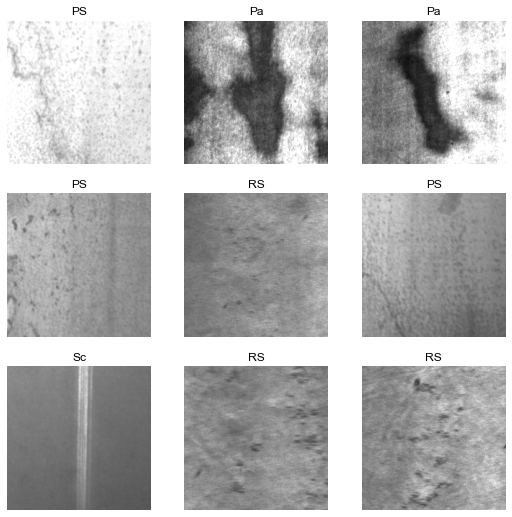

In [255]:
dls.show_batch()


Exercise 3:

Answer the following questions:
* Should or shouldn't you shuffle your data?
* What do you think about the size of the total dataset, vali

## Training a model
We will now train a model. To do this we need a type of model, for which we will use an 18 block residual net by default (resnet18). Since we have very little data we definitely need transfer learning. To use model parameters trained on Imagenet we use the flag pretrained=True. Our own dataset we already prepared, so now all we need is to optimize it for a certain error or loss function. The standard optimizer is called Adam and works fairly well. The standard loss function is the [cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [260]:
learn = cnn_learner(dls, resnet18, pretrained=True)


While deep learning does not have too many essential hyperparameters, we must determine the step size or learning rate of our gradient descent optimizer. Rather than choosing random values and seeing how this affects our entire training procedure, we will determine our maximum learning rate with a learning rate finder. The learning rate finder will perform an optimization step for a series of batches and see which learning rate causes the largest decrease in loss function. 

SuggestedLRs(steep=0.0006918309954926372)


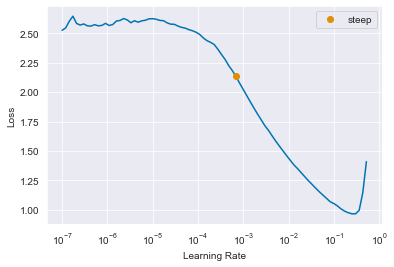

In [263]:
lr = learn.lr_find(suggest_funcs=(steep))
print(lr.steep)

We see the typical behavior of a learning rate finder. We will choose the learning rate at the point of steepest descent.

## Exercise 3:
Try the learning rate finder with different batch sizes. 
* What is the effect of a very small batch size on the learning rate?
* What is the effect of a very large batch size?
* What learning rate do you choose in both cases?

Next we will train our model using our selected learning rate. We will use the finetune function since we are performing transfer learning. We will keep our pretrained features frozen for 1 epoch, an epoch being one pass through our dataset. During this time we only update the final output layers of our model, based on imagenet features. Afterwards we train all parameters for another ten epochs, with a learning rate that is automatically halved.

In [258]:
?learn.fine_tune

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Docstring: Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR
File:      c:\users\michaelsluydts\.conda\envs\fastai\lib\site-packages\fastai\callback\schedule.py
Type:      method


In [268]:
learn.fine_tune(10, base_lr=lr.steep, freeze_epochs=1)

The learning rate is actually varied according to a schedule using this function. The optimal schedule depends on your optimizer. Let's have a look at what it looked like.

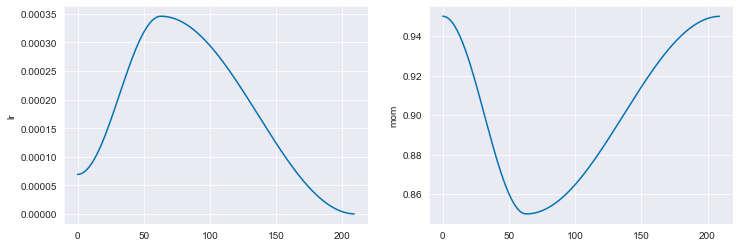

In [269]:
learn.recorder.plot_sched()

This graph only shows the evolution during the unfrozen cycle. It gradually warms up the learning rate, and then it starts to decay. This allows the suboptimal initial weights to gradually adapt before making any drastic changes, similar to simulated annealing. Let's finally have a look at our loss.

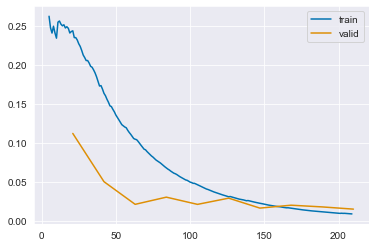

In [270]:
learn.recorder.plot_loss()

We see our training loss dropped gradually, with the largest decay when we had the largest step size. The validation less saturated much quicker. We should be careful with overfitting, though the loss did not go up at the end. This means we are probably fine, but could add regularization. We definitely don't need to train longer.

## Exercise 4:
* Try comparing a pretrained vs a randomly initialized model. How does it perform?
* Try changing the model size using a pretrained model (or optionally also a random model), how does the model size affect the loss? The following modelsare available: resnet34, resnet50, resnet101, resnet152
* You can also try varying the ratio of frozen to normal epochs. Can you reach the same loss even faster?
* How does the model size affect the compute time?
* How does it affect the GPU memory and load?
* Compare cpu and gpu speed by giving the learner device=torch.device('cpu') vs torch.device('cuda')

## Interpreting the results
Loss of course does not tell us everything so let's have a look at how we can interpret our results. Let's look at the classification of a random batch.

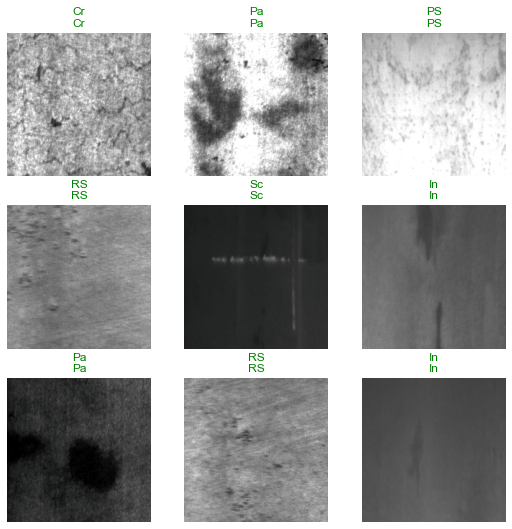

In [271]:
learn.show_results()


Matching labels are shown in green, wrong classifications are shown in red. To get a better idea of what is going wrong let's look at the worst performing images.

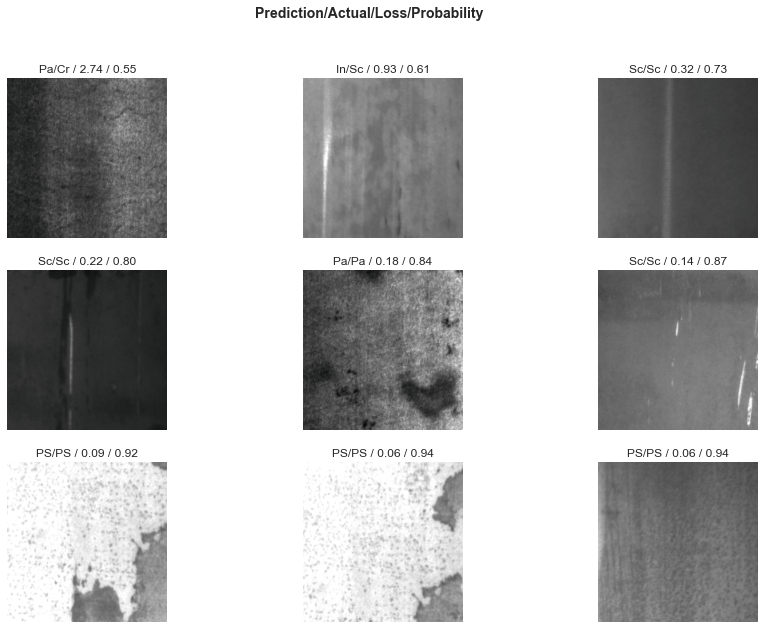

In [272]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))


At this time only two wrong images, the first has some clear contrast issues which the model mistakes for a patch, the escond has a bright reflection it thinks is a scratch. This makes perfect sense! The issue is more with the data quality. The others it doubts about but still classifies right. We see especially the pitted surface has some weird contours, while the scratch above is extremely dark. Let's look at the confusion matrix to get an idea of our global performance on the validation set.

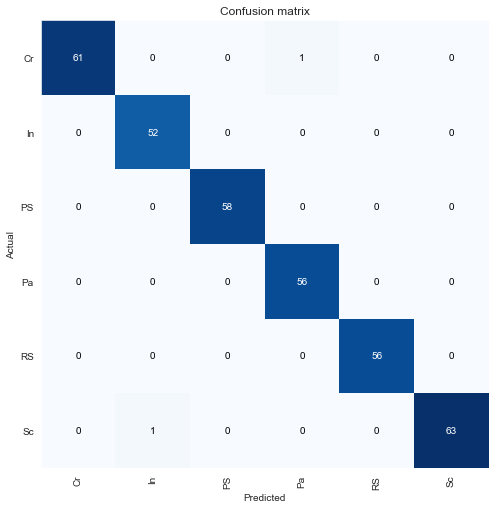

In [274]:
interp.plot_confusion_matrix(figsize=(7,7))


Well, that sure is good for a few minutes training. Since our dataset is so small, can we guarantee this will still work on new images though? Let's look at our test set and try altering the images slightly through augmentation.

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


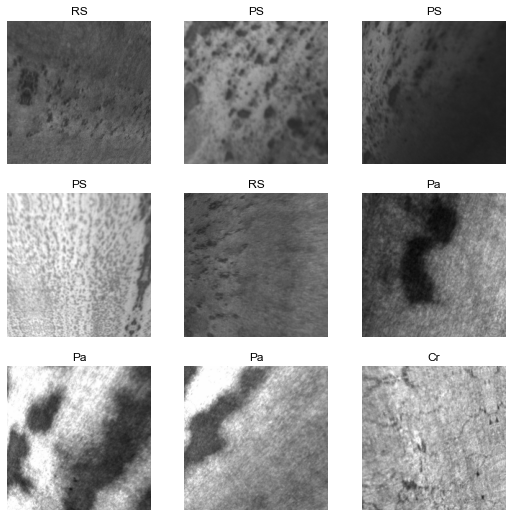

In [275]:
test_files = get_image_files(path / 'test') # we get a list of all the files in the folder

test_dls = ImageDataLoaders.from_name_func(path, test_files, get_label, bs=16, batch_tfms=aug_transforms(mult=1.0,
                do_flip=True,
                flip_vert=True,
                max_rotate=45.0,
                min_zoom=0.8,
                max_zoom=1.2,
                max_lighting=0.1,
                max_warp=0.3,
                p_affine=0.75,
                p_lighting=0.75,
                xtra_tfms=None,
                size=None,
                mode='bilinear',
                pad_mode='reflection',
                align_corners=True,
                batch=False,
                min_scale=1.0), shuffle=True)

test_dls.train.show_batch()
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls.train)

We see the images are now rotated under altered lighting and show some distortion, a much better test.

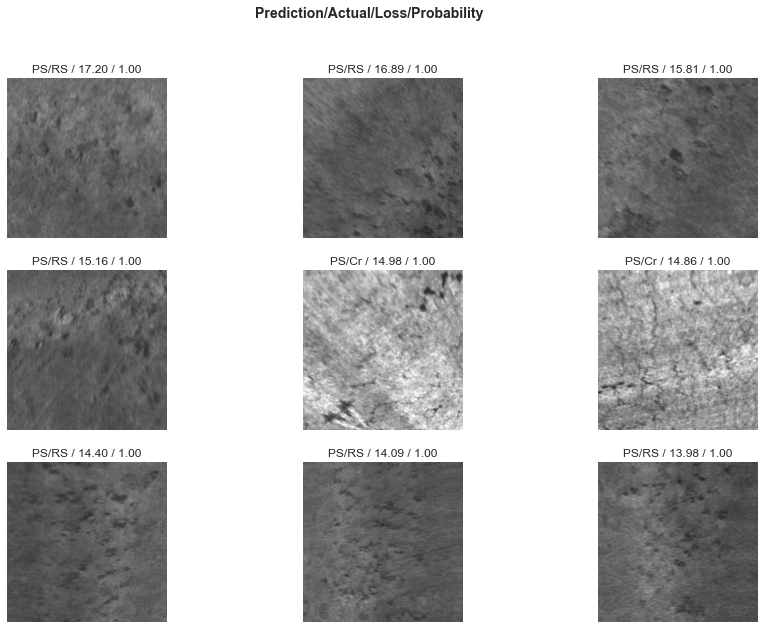

In [276]:
test_interp.plot_top_losses(9, figsize=(15,10))


Ouch.

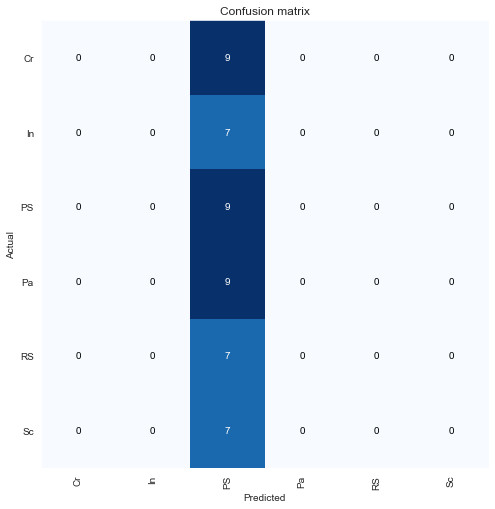

In [277]:
test_interp.plot_confusion_matrix(figsize=(7,7))


We miserably fail. The model assumed very specific conditions of the images and likely tried to cheat a bit due to the overlapping of some images in the dataset.

## Exercise 5:
* Try fixing this by adding augmentation to training. Do you get better result?

# SHAP
While we understand what goes right and wrong in our dataset, we don't yet understand *how* our AI makes its decisions. Luckily, the field of explainable AI has provided us several methods to help figure this out. We'll be using the SHAP method to determine the impact of each input feature, each pixel, of our image. Since this is an introductory session, we'll focus on demonstrating this rather than explaining all of the theory. Let's first install SHAP.

In [278]:
! pip install shap

Next, we give the model a set of background images to learn to understand the dataset, then we determine the SHAP values for new images. This can take a few minutes...

In [279]:
import shap 
batch = next(iter(test_dl))
images, _ = batch
num_samples = 8
background = images[:num_samples]
test_images = images[num_samples:]

e = shap.GradientExplainer(learn.model.cuda(), background.cuda())
shap_values = e.shap_values(test_images.cuda())

We then plot the SHAP values, one for each pixel as a mask on top of our image. Red values contribute strongly to a positive classification for a class, blue to a negative.

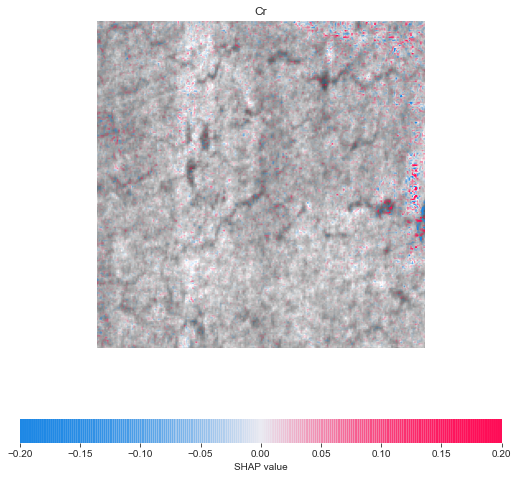

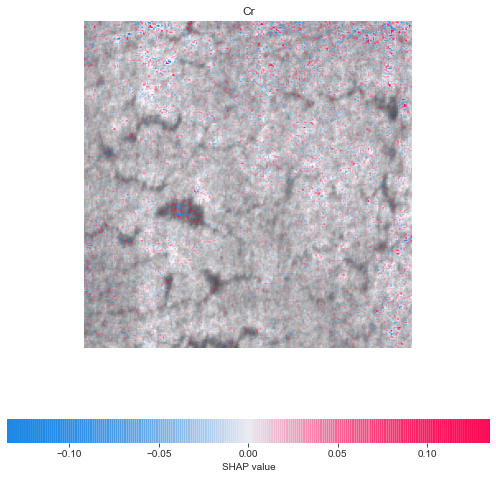

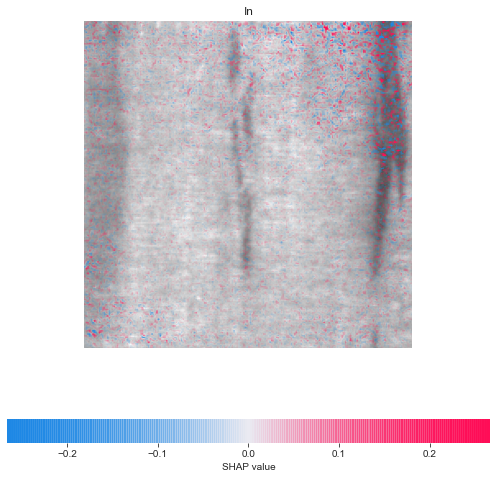

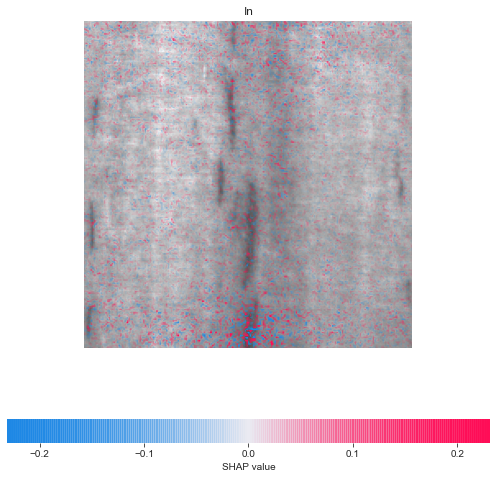

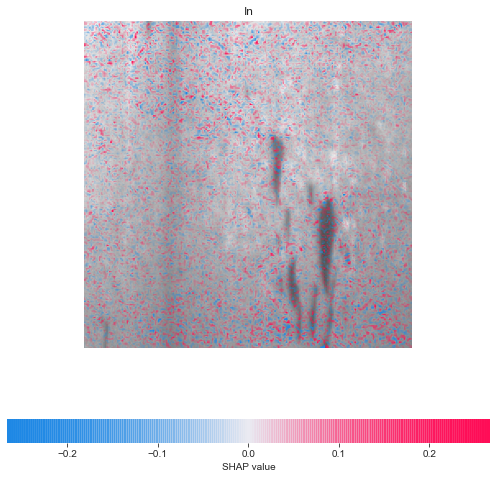

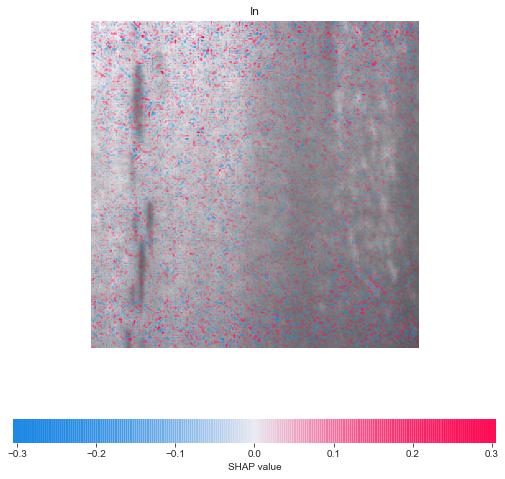

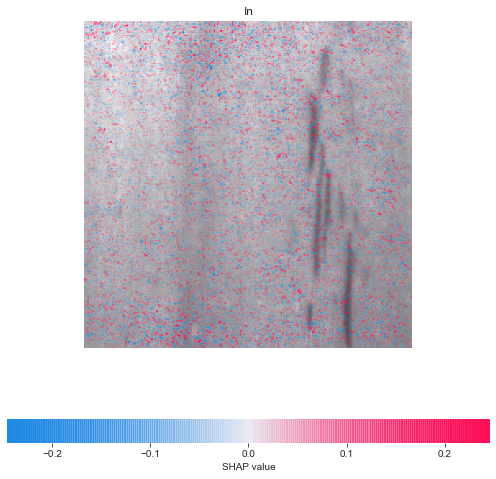

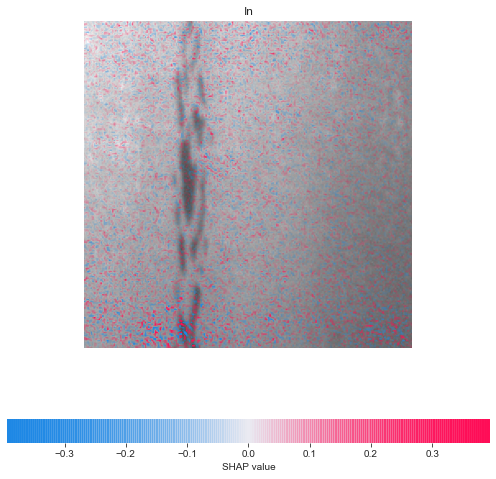

In [280]:
#https://melhanna.com/fastai-explainability-with-shap/

import matplotlib.pyplot as pl
from shap.plots import colors

for idx, x in enumerate(batch[0][num_samples:num_samples+8]):
    x = x.cpu() # move image to CPU
    label = dls.train.vocab[batch[1][num_samples:num_samples+8]][idx]
    sv_idx = list(dls.train.vocab).index(label)

    # plot our explanations
    fig, axes = pl.subplots(figsize=(7, 7))

    # make sure we have a 2D array for grayscale
    if len(x.shape) == 3 and x.shape[2] == 1:
        x = x.reshape(x.shape[:2])
    if x.max() > 1:
        x /= 255.

    # get a grayscale version of the image
    x_curr_gray = (
        0.2989 * x[0,:,:] +
        0.5870 * x[1,:,:] +
        0.1140 * x[2,:,:]
    )
    x_curr_disp = x

    abs_vals = np.stack(
        [np.abs(shap_values[sv_idx][idx].sum(0))], 0
    ).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    label_kwargs = {'fontsize': 12}
    axes.set_title(label, **label_kwargs)

    sv = shap_values[sv_idx][idx].sum(0)
    axes.imshow(
        x_curr_gray,
        cmap=pl.get_cmap('gray'),
        alpha=0.7,
        extent=(-1, sv.shape[1], sv.shape[0], -1)
    )
    im = axes.imshow(
        sv,
        cmap=colors.red_transparent_blue, 
        vmin=-max_val, 
        vmax=max_val
    )
    axes.axis('off')

    fig.tight_layout()

    cb = fig.colorbar(
        im, 
        ax=np.ravel(axes).tolist(),
        label="SHAP value",
        orientation="horizontal"
    )
    cb.outline.set_visible(False)
    pl.show()

Exercise 6:
* Does the model interpret defects in the same way as you? What does it do?
* Compare with your augmented model. What's the difference?
* (optional) How does a model try to interpret the image if it was trained with a batch size that was too small. Feel free to compare with other models.